In [4]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [5]:
import sys
import os
import numpy as np
import scipy as sp
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
from sklearn import preprocessing
from sklearn.metrics import *
import datetime
from scipy import stats

from cvxpy import *

The Don

A group of mobsters and their leader just robbed a bank and are short on time before
the police arrive in time $T$. To divide the loot, they each simulatenously take any amount $p_t$ 
up to some maximum for some number of rounds $T$, for which they receive concave utility $g(p_t)$.
While supervising the heist, the Don reminds the mobsters who's in charge by collecting
a hefty fee from each mobster on the round when the gange collectively take the most money.

The fee for mobster $i$ is equal to $d * p_{t, i}$. The goal for each mobster is to maximize
$\sum_{t} g(p_{t})$. What is the optimal strategy? What happens when $d*p_{t,i} < g(p_{t})$, 
$d*p_{t,i} > g(p_{t})$, and $d*p_{t,i} >> g(p_{t})$?

In [273]:
rounds = 100
players = 5
max_draw = 1

def log_utility(draw):
    return(np.log(draw + 1))

def fix_strategy(draw=max_draw):
    return(draw)

def uniform_noisy_strategy(draw=max_draw, noise_factor=0.1):
    dout = draw - np.random.uniform(0,noise_factor)
    return(dout)

def uniform_random_strategy(draw=max_draw):
    return(np.random.uniform(0,draw))
    

In [3]:
#all fixed_strategy
#d is large
#linear utility

#fixed max is a stable equillibrium because
#if any player takes less than max, that's not
#the peak, and therefore they receive less

d = 10 #0.5, 1, 10, 80

player_rewards = {}
for p in range(players):
    player_rewards[p] = []

pool = 100000 #larger than any possible total game draw

#play game
round_sizes = []
for r in range(rounds):
    round_size = 0
    for p in range(players):
        draw = fix_strategy()
        player_rewards[p].append(draw)
        round_size += draw
        pool -= draw
    round_sizes.append(round_size)

#run mafia tax
print(np.argmax(round_sizes), np.max(round_sizes))
end_player_rewards = {}
for p in range(players):
    end_player_rewards[p] = 0

for p in range(players):
    tax = d * player_rewards[p][np.argmax(round_sizes)]
    end_player_rewards[p] = np.sum(player_rewards[p]) - tax

print(end_player_rewards)

0 5
{0: 90, 1: 90, 2: 90, 3: 90, 4: 90}


In [21]:
#one noisy player
#d is large
#linear utility

d = 50 #0.5, 1, 10, 80

player_rewards = {}
for p in range(players):
    player_rewards[p] = []

pool = 2 * rounds * players * max_draw #larger than any possible total game draw

#play game
round_sizes = []
for r in range(rounds):
    round_size = 0
    for p in range(players):
        if p == 0:
            draw = uniform_noisy_strategy(noise_factor=0.01)
            player_rewards[p].append(draw)
        else:
            draw = fix_strategy()
            player_rewards[p].append(draw)
        round_size += draw
        pool -= draw
    round_sizes.append(round_size)

#run mafia tax
print(np.argmax(round_sizes), np.max(round_sizes))
end_player_rewards = {}
for p in range(players):
    end_player_rewards[p] = 0

for p in range(players):
    tax = d * player_rewards[p][np.argmax(round_sizes)]
    end_player_rewards[p] = np.sum(player_rewards[p]) - tax

print(end_player_rewards)

86 4.999956033577068
{0: 49.50868757669949, 1: 50, 2: 50, 3: 50, 4: 50}


In [24]:
#all random players
#d is large
#linear utility

#play many games to see expected reward

MC = 1000
all_game_rewards = {}
for p in range(players):
    all_game_rewards[p] = []
    
for i in range(MC):
    d = 50 #0.5, 1, 10, 80

    player_rewards = {}
    for p in range(players):
        player_rewards[p] = []

    pool = 2 * rounds * players * max_draw #larger than any possible total game draw

    #play game
    round_sizes = []
    for r in range(rounds):
        round_size = 0
        for p in range(players):
            draw = uniform_random_strategy()
            round_size += draw
            pool -= draw
            player_rewards[p].append(draw)
        round_sizes.append(round_size)

    #run mafia tax
    #print(np.argmax(round_sizes), np.max(round_sizes))
    end_player_rewards = {}
    for p in range(players):
        end_player_rewards[p] = 0

    for p in range(players):
        tax = d * player_rewards[p][np.argmax(round_sizes)]
        all_game_rewards[p].append( np.sum(player_rewards[p]) - tax )

expected_rewards = {}
for p in range(players):
    expected_rewards[p] = np.mean(all_game_rewards[p])
    
print(expected_rewards)

{0: 9.510289135942758, 1: 9.60380807210543, 2: 9.786756859141825, 3: 9.263393519864092, 4: 9.29197150286795}


In [38]:
#one fixed player
#d is large
#linear utility

#play many games to see expected reward

MC = 1000
all_game_rewards = {}
for p in range(players):
    all_game_rewards[p] = []
    
for i in range(MC):
    d = 50 #0.5, 1, 10, 80

    player_rewards = {}
    for p in range(players):
        player_rewards[p] = []

    pool = 2 * rounds * players * max_draw #larger than any possible total game draw

    #play game
    round_sizes = []
    for r in range(rounds):
        round_size = 0
        for p in range(players):
            if p == 0:
                draw = fix_strategy()
                player_rewards[p].append(draw)
            else:
                draw = uniform_random_strategy()
                player_rewards[p].append(draw)
            round_size += draw
            pool -= draw
            
        round_sizes.append(round_size)

    #run mafia tax
    #print(np.argmax(round_sizes), np.max(round_sizes))
    end_player_rewards = {}
    for p in range(players):
        end_player_rewards[p] = 0

    for p in range(players):
        tax = d * player_rewards[p][np.argmax(round_sizes)]
        all_game_rewards[p].append( np.sum(player_rewards[p]) - tax )

expected_rewards = {}
for p in range(players):
    expected_rewards[p] = np.mean(all_game_rewards[p])
    
print(expected_rewards)

{0: 50.0, 1: 8.009807612653564, 2: 8.05079454749581, 3: 7.854265378944513, 4: 7.5962878061334305}


In [49]:
#one fixed player
#d is large
#concave utility

#play many games to see expected reward

MC = 1000
all_game_rewards = {}
for p in range(players):
    all_game_rewards[p] = []
    
for i in range(MC):
    d = 50 #0.5, 1, 10, 80

    player_draws = {}
    for p in range(players):
        player_draws[p] = []

    pool = 2 * rounds * players * max_draw #larger than any possible total game draw

    #play game
    round_sizes = []
    for r in range(rounds):
        round_size = 0
        for p in range(players):
            if p == 0:
                draw = fix_strategy()
                player_draws[p].append(draw)
            else:
                draw = uniform_random_strategy()
                player_draws[p].append(draw)
            round_size += draw
            pool -= draw
            
        round_sizes.append(round_size)

    #run mafia tax
    #print(np.argmax(round_sizes), np.max(round_sizes))
    end_player_rewards = {}
    for p in range(players):
        end_player_rewards = 0

    for p in range(players):
        tax = d * player_draws[p][np.argmax(round_sizes)]
        all_game_rewards[p].append( np.sum(log_utility(np.asarray(player_draws[p]))) - tax )

expected_rewards = {}
for p in range(players):
    expected_rewards[p] = np.mean(all_game_rewards[p])
    
print(expected_rewards)

#calculate what perfect post hoc could have been
np.sum(log_utility(np.asarray([max_draw for i in range(rounds - 1)])))

{0: 19.31471805599454, 1: -3.2787719320539956, 2: -3.8346351660434284, 3: -3.7472303413863224, 4: -3.4775634119773744}


68.62157087543459

In [65]:
#one fixed player
#one noisy player
#d is large
#concave utility

#play many games to see expected reward

MC = 1000
all_game_rewards = {}
for p in range(players):
    all_game_rewards[p] = []
    
for i in range(MC):
    d = 50 #0.5, 1, 10, 80

    player_draws = {}
    for p in range(players):
        player_draws[p] = []

    pool = 2 * rounds * players * max_draw #larger than any possible total game draw

    #play game
    round_sizes = []
    for r in range(rounds):
        round_size = 0
        for p in range(players):
            if p == 0:
                draw = fix_strategy()
                player_draws[p].append(draw)
            elif p == 1:
                draw = uniform_noisy_strategy(noise_factor=0.1)
                player_draws[p].append(draw)
            else:
                draw = uniform_random_strategy()
                player_draws[p].append(draw)
            round_size += draw
            pool -= draw
            
        round_sizes.append(round_size)

    #run mafia tax
    #print(np.argmax(round_sizes), np.max(round_sizes))
    end_player_rewards = {}
    for p in range(players):
        end_player_rewards = 0

    for p in range(players):
        tax = d * player_draws[p][np.argmax(round_sizes)]
        all_game_rewards[p].append( np.sum(log_utility(np.asarray(player_draws[p]))) - tax )

expected_rewards = {}
for p in range(players):
    expected_rewards[p] = np.mean(all_game_rewards[p])
    
print(expected_rewards)

#calculate what perfect post hoc could have been
np.sum(log_utility(np.asarray([max_draw for i in range(rounds - 1)])))

{0: 19.31471805599454, 1: 19.023417264465163, 2: -5.575102726654444, 3: -5.626926631698089, 4: -5.6333863330697005}


68.62157087543459

So really it seems like it boils down to who has the most flexibility to outplay those who have the least. Need to import data on distribution of sizes of players and do some analysis to see what the "play" room looks like.

This game is as if I lined up all the hours that have the potential to be the CP back to back, but each hour isn't the same. All the action occurs in the play room. Even in the room between what would have been the CP and next closest system peak, if everyone backs out then the play room is exceeded and another hour becomes the system peak and every player is again subject to CP costs. The competitive version of the game means every player should still take the max to make up for all the possible lost utility because whoever blinks loses utility and some other hour is still the CP.

The best version of the game is then cooperative. In the cooperative game each player reduces as much as possible without exceeding gap between CP and next closest, they ensure maximum utility and minimum CP bill.

In [12]:


#stats.norm.cdf(X in P(x < X), mean, std)

0.5

In [6]:
#single player game with noise, two rounds

alphas = np.arange(0.01, 0.5, 0.01) #different action tolerances to test
R_p_alpha = []

for a in alphas:
    d = 1.2 #1 < d < T = 2
    p_max = 1.0 
    p_1 = p_max
    T = 2
    eps = a #tolerance for curtailment action
    delta = 0.01 #increase play by this amount + noise gap
    inc = 0.01 #search increment when determining maximum amount able to curtail by
    std = 1 #noise standard deviation

    MC_rounds = 1000
    MC_rewards = []

    for mc in range(MC_rounds):
        z_1 = np.random.normal(0,std)
        z_2 = np.random.normal(0,std)
        true_gap = z_2 - z_1
        target_gap = z_1 + delta

        #what's the probability that the round 2 gap is greater than 0
        prb_zero = 1.0 - stats.norm.cdf(0, -1.0*z_1, std)

        if prb_zero > (1.0 - eps):
            x = 0
            n_prb = prb_zero
            while n_prb > (1.0 - eps):
                n_prb = 1.0 - stats.norm.cdf(x, -1.0*z_1, std)
                if n_prb <= (1.0 - eps):
                    break
                x += inc
            p_2 = p_max - (x + delta)
        else:
            p_2 = p_max

        #compute MC round reward
        #determine largest round
        s_1 = p_1 + z_1
        s_2 = p_2 + z_2
        rounds = np.array([p_1, p_2])
        sys_rounds = np.array([s_1, s_2])
        p_c = rounds[np.argmax(sys_rounds)]
        R_m = p_1 + p_2 - (d * p_c)
        MC_rewards.append(R_m)
     
    #compute expected reward under curtailment
    R_p = np.mean(np.asarray(MC_rewards))
    R_p_alpha.append(R_p)


In [7]:
#compute fixed strategy reward
R_f = T * p_max - d * p_max

R_f_rep = [R_f for i in range(len(R_p_alpha))]

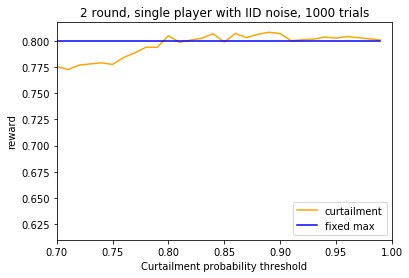

In [9]:
plt.plot(1.0 - alphas, R_p_alpha, color="orange", label="curtailment")
#plt.plot(R_p_alpha, color="orange", label="curtailment")
plt.plot(1.0 - alphas, R_f_rep, color="blue", label="fixed max")
#plt.plot(R_f_rep, color="blue", label="fixed max")
plt.xlabel("Curtailment probability threshold")
plt.ylabel("reward")
plt.title("2 round, single player with IID noise, 1000 trials")
plt.legend(loc=4)
plt.xlim(0.7,1)
#plt.ylim(0.76,0.81)
plt.show()

In [31]:
1.0 - stats.norm.cdf(5,0,1)

2.866515719235352e-07

In [242]:
def find_prob_max(beta, T):
    prob = (1 - beta)*np.exp(-1.0 * T)
    return(True)

def prob_next_t_is_max(max_z, t, T, std=1):
    p1 = 1.0/(T - t)
    p2 = 1.0 - np.power(stats.norm.cdf(max_z,0,std),(T - t))
    return(p1 * p2)
    
def prob_any_next_is_max(max_z, t, T, std=1): 
    return(1.0 - np.power(stats.norm.cdf(max_z,0,std),(T - t)))
    
def prob_next_is_max(max_z, std=1):
    return(1.0 - stats.norm.cdf(max_z,0,std))

def optimal_log_util(p_t, pi_cp):
    #for g(p) = log(p + 1)
    return( (1 - p_t*pi_cp) / (p_t*pi_cp) )

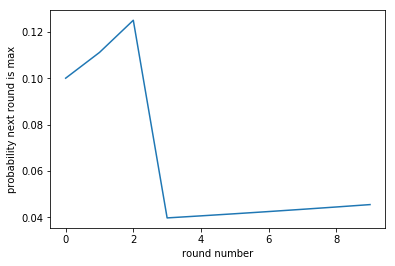

In [308]:
seq_len = 10
noise_var = 1.0
max_so_far = -np.inf
system_vals = []
probs = []

for i in range(seq_len):
    s_t = np.random.normal(0,noise_var)
    system_vals.append(s_t)
    if s_t > max_so_far:
        max_so_far = s_t
    p_t = prob_next_t_is_max(max_so_far, i, seq_len, noise_var)
    probs.append(p_t)
    
plt.plot(probs)
plt.xlabel("round number")
plt.ylabel("probability next round is max")
plt.show()

In [314]:
#MC of above

seq_len = 100
noise_var = 1.0
mc_rounds = 1000
probs_MC = np.zeros((mc_rounds, seq_len))

for mc in range(mc_rounds):


    max_so_far = -np.inf
    system_vals = []
    probs = []

    for i in range(seq_len):
        s_t = np.random.normal(0,noise_var)
        system_vals.append(s_t)
        if s_t > max_so_far:
            max_so_far = s_t
        p_t = prob_next_t_is_max(max_so_far, i, seq_len, noise_var)
        probs.append(p_t)
        
    probs_MC[mc,:] = np.asarray(probs)
    

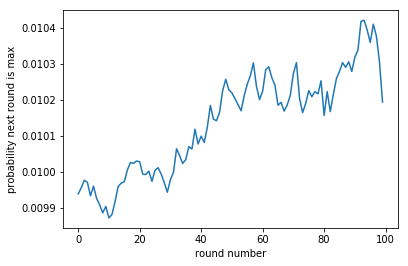

In [319]:
plt.plot(np.mean(probs_MC.T, axis=1))
plt.xlabel("round number")
plt.ylabel("probability next round is max")
plt.show()

In [296]:
rounds = np.arange(500,1000,1)
#noise_vars = np.arange(0.1,4,0.1)
#discounts = np.arange(1.1,20,0.1)
discounts = np.array([20.0])

size_2 = len(discounts) #len(noise_vars)

adaptive_scores = np.zeros((len(rounds), size_2))
fixed_scores = np.zeros((len(rounds), size_2))
perfect_scores = np.zeros((len(rounds), size_2))
mc_prob_sum = np.zeros((len(rounds), size_2))

for i in range(rounds.shape[0]):
    T = rounds[i]
    #for j in range(noise_vars.shape[0]):
    for j in range(discounts.shape[0]):
        pi_cp = discounts[j]
        #pi_cp = 1.2
        #noise_var = noise_vars[j]
        noise_var = 1.0

        MC_rounds = 1000
        mc_adaptive = []
        mc_probs = np.zeros((MC_rounds, T))
        p_max = 100.0    #large rewards w/ potentially large CP cost pi_cp*p_max

        for r in range(MC_rounds):
            max_so_far = -np.inf
            system_vals = []
            rewards = []
            probs = []
            plays = []

            for t in range(T):
                z_t = np.random.normal(0,noise_var)
                system_vals.append(z_t)
                if z_t > max_so_far:
                    max_so_far = z_t
                #p_t = (1.0/(T-(t))*(prob_max_so_far(max_so_far, t, T)))
                p_t = prob_next_t_is_max(max_so_far, t, T, noise_var)

                probs.append(p_t)

                #play = 1.0 - p_t * pi_cp #linear util
                #util = play

                play = optimal_log_util(p_t, pi_cp)  #log(x + 1) concave util
                if play < 0:
                    play = 0.0
                if play > p_max:
                    play = p_max
                util = np.log(play + 1)

                rewards.append(util)
                plays.append(play)

            mc_probs[r,:] = np.asarray(probs)
            mc_adaptive.append(np.sum(rewards) - pi_cp*plays[np.argmax(system_vals)])


        perfect = (T-1)*np.log(p_max + 1)
        fixed = T*np.log(p_max + 1) - pi_cp*p_max
        adaptive = np.mean(mc_adaptive)
        
        perfect_scores[i,j] = perfect
        fixed_scores[i,j] = fixed
        adaptive_scores[i,j] = adaptive
        mc_prob_sum[i,j] = np.sum(np.mean(mc_probs,axis=0))


print(perfect)
print(fixed)
print(adaptive)


KeyboardInterrupt: 

100.0

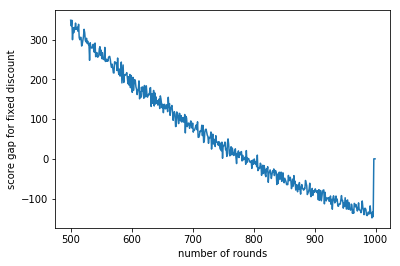

In [303]:
plt.plot(rounds, adaptive_scores - fixed_scores)
plt.xlabel("number of rounds")
plt.ylabel("score gap for fixed discount")
plt.show()

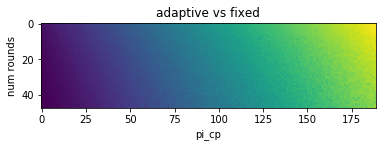

In [276]:
plt.imshow(adaptive_scores - fixed_scores)
plt.ylabel("num rounds")
plt.xlabel("pi_cp")
plt.title("adaptive vs fixed")
plt.show()

In [277]:
adaptive_scores - fixed_scores

array([[ 9.59814101e+01,  1.03229942e+02,  1.14557836e+02, ...,
         1.93339704e+03,  1.96778698e+03,  1.97281725e+03],
       [ 8.84893417e+01,  9.78734350e+01,  1.06385451e+02, ...,
         1.94608170e+03,  1.96167073e+03,  1.97233527e+03],
       [ 8.17403114e+01,  9.75162553e+01,  1.02188758e+02, ...,
         1.93435979e+03,  1.94568200e+03,  1.94533738e+03],
       ...,
       [-2.51947748e+00,  1.37093702e+00,  7.72672808e+00, ...,
         1.62771557e+03,  1.58075514e+03,  1.61048837e+03],
       [-3.64655601e+00, -1.55386977e+00,  8.23547648e+00, ...,
         1.56017390e+03,  1.57500720e+03,  1.64866659e+03],
       [-1.48883519e+00, -7.13619255e-01, -6.70184835e-01, ...,
         1.63040250e+03,  1.61474059e+03,  1.67439200e+03]])

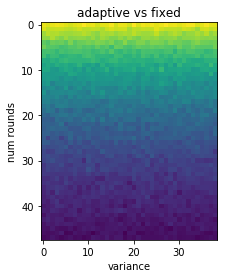

In [272]:
plt.imshow(adaptive_scores - fixed_scores)
plt.ylabel("num rounds")
plt.xlabel("variance")
plt.title("adaptive vs fixed")
plt.show()

In [237]:
#increasing number of rounds
#range of variances
#what does sums of sequences of "next round is max" probabilities look like

rounds = np.arange(20,80,1)
noise_vars = np.arange(0.1,2,0.1)

sums = np.zeros((len(rounds), len(noise_vars)))

for i in range(len(rounds)):
    T = rounds[i]
    for j in range(len(noise_vars)):
        noise_var = noise_vars[j]
        #compute sequence
        probs = []
        max_z_so_far = -np.inf
        for t in range(T):
            z_t = np.random.normal(0,noise_var)
            if z_t > max_so_far:
                max_so_far = z_t
            p_t = prob_next_t_is_max(max_so_far, t, T)
            probs.append(p_t)
        sums[i,j] = np.sum(probs)

In [241]:
prob_next_t_is_max(0.0, )

0.0

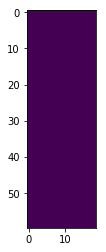

In [238]:
plt.imshow(sums)
plt.show()

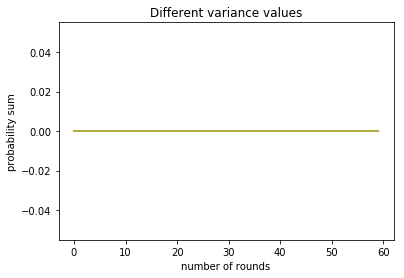

In [239]:
plt.plot(sums)
plt.ylabel("probability sum")
plt.xlabel("number of rounds")
plt.title("Different variance values")
plt.show()

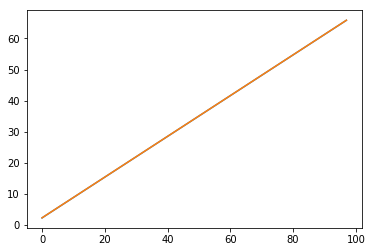

In [175]:
plt.plot(np.mean(np.exp(sums), axis=1))
plt.plot(0.6552060180719781*np.arange(2,100,1) + 1)
plt.show()


In [174]:
line - 0.6552060180719781*np.arange(2,100,1)

array([0.971855  , 0.98875166, 0.98780699, 0.9870579 , 0.98654291,
       0.98613141, 0.98580888, 0.98555039, 0.98534008, 0.98516466,
       0.9850172 , 0.98489194, 0.98478481, 0.98469217, 0.98461168,
       0.98454138, 0.9844797 , 0.9844254 , 0.98437743, 0.98433495,
       0.98429727, 0.9842638 , 0.98423404, 0.98420758, 0.98418405,
       0.98416314, 0.98414459, 0.98412817, 0.98411368, 0.98410093,
       0.98408977, 0.98408007, 0.9840717 , 0.98406454, 0.98405851,
       0.98405351, 0.98404947, 0.98404632, 0.98404399, 0.98404242,
       0.98404157, 0.98404138, 0.9840418 , 0.98404281, 0.98404436,
       0.98404642, 0.98404896, 0.98405195, 0.98405536, 0.98405917,
       0.98406336, 0.98406791, 0.98407279, 0.98407799, 0.9840835 ,
       0.98408929, 0.98409536, 0.98410168, 0.98410825, 0.98411506,
       0.98412209, 0.98412933, 0.98413678, 0.98414442, 0.98415224,
       0.98416025, 0.98416842, 0.98417676, 0.98418525, 0.98419389,
       0.98420268, 0.9842116 , 0.98422065, 0.98422983, 0.98423

In [172]:
0.655*np.arange(2,100,1)

array([ 1.31 ,  1.965,  2.62 ,  3.275,  3.93 ,  4.585,  5.24 ,  5.895,
        6.55 ,  7.205,  7.86 ,  8.515,  9.17 ,  9.825, 10.48 , 11.135,
       11.79 , 12.445, 13.1  , 13.755, 14.41 , 15.065, 15.72 , 16.375,
       17.03 , 17.685, 18.34 , 18.995, 19.65 , 20.305, 20.96 , 21.615,
       22.27 , 22.925, 23.58 , 24.235, 24.89 , 25.545, 26.2  , 26.855,
       27.51 , 28.165, 28.82 , 29.475, 30.13 , 30.785, 31.44 , 32.095,
       32.75 , 33.405, 34.06 , 34.715, 35.37 , 36.025, 36.68 , 37.335,
       37.99 , 38.645, 39.3  , 39.955, 40.61 , 41.265, 41.92 , 42.575,
       43.23 , 43.885, 44.54 , 45.195, 45.85 , 46.505, 47.16 , 47.815,
       48.47 , 49.125, 49.78 , 50.435, 51.09 , 51.745, 52.4  , 53.055,
       53.71 , 54.365, 55.02 , 55.675, 56.33 , 56.985, 57.64 , 58.295,
       58.95 , 59.605, 60.26 , 60.915, 61.57 , 62.225, 62.88 , 63.535,
       64.19 , 64.845])

In [170]:
line = np.mean(np.exp(sums), axis=1)
print((line[80]-line[20])/(79 - 19))

0.6552060180719781


In [116]:
#linear utility
#probabilistic maximization

rounds = np.arange(10,100,1)
max_x = 1 
noise_var = 1

perfect_scores = np.zeros((rounds.shape[0],1000))
fixed_scores = np.zeros((rounds.shape[0],1000))
adaptive_scores = np.zeros((rounds.shape[0],1000))

for i in range(rounds.shape[0]):
    T = rounds[i]
    penalties = np.arange(1,T-1,(T-2)/1000)
    for j in range(1000):
        
        pi_cp = penalties[j]
        max_so_far = -np.inf
        system_vals = []
        rewards = []
        probs = []
        plays = []

        for t in range(T):
            z_t = np.random.normal(0,noise_var)
            system_vals.append(z_t)
            if z_t > max_so_far:
                max_so_far = z_t
            p_t = (1.0/(T-t))*(1.0 - prob_max_so_far(max_so_far, t, T))
            probs.append(p_t)
            play = 1.0 - p_t * pi_cp
            rewards.append(play)
            plays.append(play)
            
        perfect = T - 1
        fixed = T - pi_cp
        adaptive = np.sum(rewards) - pi_cp*plays[np.argmax(system_vals)]
        
        perfect_scores[i,j] = perfect
        fixed_scores[i,j] = fixed
        adaptive_scores[i,j] = adaptive
    
    



KeyboardInterrupt: 

In [ ]:
adaptive_scores

In [ ]:
perfect_scores

In [ ]:
np.divide(adaptive_scores,perfect_scores)

In [51]:
print(np.sum(rewards))
print(T - pi_cp)
print(T - 1)

87.30836700098617
70.0
99


In [82]:
#compute probability of maximum
#compute probability of having already seen maximum

#linear utility, p_max = 1

T = 100.0
z_max = -np.inf
MC_rounds = 1000


#for mc in range(MC_rounds):
retrospective_max = []

values = []

z_maxes = []

for i in range(int(T)):
    z = np.random.normal(0,1)
    values.append(z)
    if z > z_max:
        z_max = z
    z_maxes.append(z_max)
    retrospective_max.append(prob_max_so_far(z_max, i, T))
    

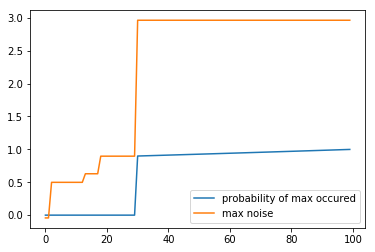

In [83]:
plt.plot(retrospective_max, label="probability of max occured")
plt.plot(z_maxes, label="max noise")
plt.legend()
plt.show()


In [76]:
#compute probability of maximum
#compute probability of having already seen maximum

T = 100.0

z_max = -np.inf
MC_rounds = 1000

max_round = []
trials_prob = np.zeros((MC_rounds,int(T)))


for mc in range(MC_rounds):
    retrospective_max = []
    values = []
    z_maxes = []

    for i in range(int(T)):
        z = np.random.normal(0,1)
        values.append(z)
        if z > z_max:
            z_max = z
        z_maxes.append(z_max)
        retrospective_max.append(prob_max_so_far(z_max, i, T))
        
    max_round.append(np.argmax(np.asarray(values)))
    trials_prob[mc,:] = np.asarray(retrospective_max)
    

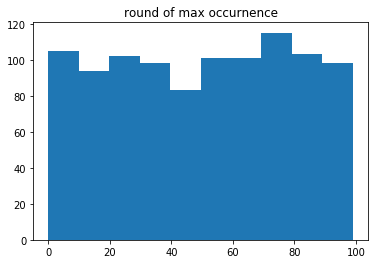

In [77]:
plt.hist(max_round)
plt.title("round of max occurnence")
plt.show()

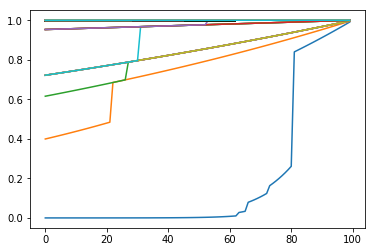

In [78]:
plt.plot(trials_prob.T)
plt.show()

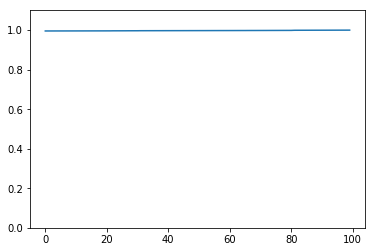

In [79]:
plt.plot(np.mean(trials_prob,0))
plt.ylim(0,1.1)
plt.show()